<img src='images/Northwind_ERD_updated.png.'>

List of testing:
- One sample z test (know pop variance) - will not be able to test with this data
    - Kolmogorov-Smirnov Test
- One sample t test (don't know pop variance)
- Two way ANOVA
    - Tukey's (confirmatory)
- One Sample Proportion Testing
- Chi-Square
- Two Sample Proportion Testing/Two Sample Chi Square
- Bayesian Testing

# Question

### Does having a product on reorder increase spending? Is this connected to frieght?

Both questions can be tested using a paired sample t-test.

# Hypothesis

## H0: no effect - there is no change to spending based on reorder or frieght costs
## HA: there is an effect - there is a change to spending based on reorder or frieght costs

## Feature: spending
## Target: reorder/frieght

# Methodology

To evaluate the data provided by Northwind_ERD, I have chosen to use the following steps:
- Obtain Data
- Scrub Data
- Explore Data
- Modeling
- Interpret

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

# Obtain Data

The data we're evaluating comes from the 'Northwind_small.sqlite' file in this repository. We'll need to pull the following tables and the following lines of information:

- Product
    - ProductId
    - ReorderLevel
- Order
    - OrderId
    - ShipVia
    - Frieght
- OrderDetail
    - OrderId
    - ProductId
    - UnitPrice
    - Quantity

In [1]:
# import py file
from classes import pvalue

In [2]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('Solarize_Light2')
import seaborn as sns

idx = pd.IndexSlice

### Setting up the connection with the database

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

### Looking at the necessary data

In [4]:
# Order data
cur.execute("""SELECT *
               FROM 'Order';
               """)
df_order = pd.DataFrame(cur.fetchall())
df_order.columns = [x[0] for x in cur.description]
df_order.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [5]:
# OrderDetail data
cur.execute("""SELECT *, UnitPrice*Quantity as OrderTotal
               FROM OrderDetail;
               """)
df_orderdetail = pd.DataFrame(cur.fetchall())
df_orderdetail.columns = [x[0] for x in cur.description]
df_orderdetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [6]:
df_orderdetail['ProductId'].max()

77

In [7]:
# Product data
cur.execute("""SELECT *
               FROM Product;
               """)
df_product = pd.DataFrame(cur.fetchall())
df_product.columns = [x[0] for x in cur.description]
df_product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [8]:
# total number of prodcuts
len(df_product['ReorderLevel'])

77

In [9]:
# number of products without reorder
sum(df_product['ReorderLevel'] == 0)

24

In [10]:
df_product[df_product['ReorderLevel'] == 0].sample(10)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
70,71,Flotemysost,15,4,10 - 500 g pkgs.,21.50,26,0,0,0
28,29,Thüringer Rostbratwurst,12,6,50 bags x 30 sausgs.,123.79,0,0,0,1
64,65,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,21.05,76,0,0,0
7,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00,6,0,0,0
61,62,Tarte au sucre,29,3,48 pies,49.30,17,0,0,0
23,24,Guaraná Fantástica,10,1,12 - 355 ml cans,4.50,20,0,0,1
11,12,Queso Manchego La Pastora,5,4,10 - 500 g pkgs.,38.00,86,0,0,0
8,9,Mishi Kobe Niku,4,6,18 - 500 g pkgs.,97.00,29,0,0,1
41,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
17,18,Carnarvon Tigers,7,8,16 kg pkg.,62.50,42,0,0,0


In [11]:
# number of products with a reorder
sum(df_product['ReorderLevel'] != 0)

53

In [12]:
df_product[df_product['ReorderLevel'] != 0].sample(10)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
65,66,Louisiana Hot Spiced Okra,2,2,24 - 8 oz jars,17.00,4,100,20,0
50,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0
63,64,Wimmers gute Semmelknödel,12,5,20 bags x 4 pieces,33.25,22,80,30,0
12,13,Konbu,6,8,2 kg box,6.00,24,0,5,0
48,49,Maxilaku,23,3,24 - 50 g pkgs.,20.00,10,60,15,0
66,67,Laughing Lumberjack Lager,16,1,24 - 12 oz bottles,14.00,52,0,10,0
55,56,Gnocchi di nonna Alice,26,5,24 - 250 g pkgs.,38.00,21,10,30,0
42,43,Ipoh Coffee,20,1,16 - 500 g tins,46.00,17,10,25,0
30,31,Gorgonzola Telino,14,4,12 - 100 g pkgs,12.50,0,70,20,0
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0


It looks like there are duplicates because the index is the same, but the item total is different. I think it might be a good idea to incorporate the item number to ensure unique indexing.

In [83]:
# All data
cur.execute("""SELECT 'Order'.Id, ShipVia, Freight, Product.UnitPrice as ProductPrice, OrderDetail.UnitPrice as OrderPrice, Quantity, ReorderLevel, OrderDetail.ProductId
               FROM OrderDetail
               LEFT JOIN 'Order' ON OrderDetail.OrderID = 'Order'.Id
               JOIN Product ON OrderDetail.ProductId = Product.Id
               ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,ShipVia,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,ProductId
0,10248,3,32.38,21.00,14.0,12,30,11
1,10248,3,32.38,14.00,9.8,10,0,42
2,10248,3,32.38,34.80,34.8,5,0,72
3,10249,1,11.61,23.25,18.6,9,0,14
4,10249,1,11.61,53.00,42.4,40,10,51


In [84]:
# total number of orders to be evaluated
len(df['Id'].unique())

830

In [85]:
table = pd.pivot_table(data=df, index=('Id', 'ShipVia', 'ProductId'), aggfunc=sum,)
table.head()

Freight  OrderPrice  ProductPrice  Quantity  \
Id    ShipVia ProductId                                                
10248 3       11           32.38        14.0         21.00        12   
              42           32.38         9.8         14.00        10   
              72           32.38        34.8         34.80         5   
10249 1       14           11.61        18.6         23.25         9   
              51           11.61        42.4         53.00        40   

                         ReorderLevel  
Id    ShipVia ProductId                
10248 3       11                   30  
              42                    0  
              72                    0  
10249 1       14                    0  
              51                   10

In [86]:
df.columns

Index(['Id', 'ShipVia', 'Freight', 'ProductPrice', 'OrderPrice', 'Quantity',
       'ReorderLevel', 'ProductId'],
      dtype='object')

In [87]:
multi = df.copy(deep=True)
mulit = multi.set_index(['Id', 'ShipVia', 'ProductId'], inplace=True)
multi.head()

Freight  ProductPrice  OrderPrice  Quantity  \
Id    ShipVia ProductId                                                
10248 3       11           32.38         21.00        14.0        12   
              42           32.38         14.00         9.8        10   
              72           32.38         34.80        34.8         5   
10249 1       14           11.61         23.25        18.6         9   
              51           11.61         53.00        42.4        40   

                         ReorderLevel  
Id    ShipVia ProductId                
10248 3       11                   30  
              42                    0  
              72                    0  
10249 1       14                    0  
              51                   10

In [88]:
sort1 = multi.copy()
sort1.sort_index(inplace=True)
sort1.head(10)

Freight  ProductPrice  OrderPrice  Quantity  \
Id    ShipVia ProductId                                                
10248 3       11           32.38         21.00        14.0        12   
              42           32.38         14.00         9.8        10   
              72           32.38         34.80        34.8         5   
10249 1       14           11.61         23.25        18.6         9   
              51           11.61         53.00        42.4        40   
10250 2       41           65.83          9.65         7.7        10   
              51           65.83         53.00        42.4        35   
              65           65.83         21.05        16.8        15   
10251 1       22           41.34         21.00        16.8         6   
              57           41.34         19.50        15.6        15   

                         ReorderLevel  
Id    ShipVia ProductId                
10248 3       11                   30  
              42                    0  
              72                    0  
10249 1       14                    0  
              51                   10  
10250 2       41                   10  
              51                   10  
              65                    0  
10251 1       22                   25  
              57                   20

In [89]:
# only shipping for company 1
company_1 = sort1.loc[idx[:, 1], :]
company_1.sample(10)

,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel
Id,ShipVia,ProductId,,,,,
10406,1,21,108.04,10.00,8.00,30,5
10418,1,47,17.55,9.50,7.60,55,0
10600,1,54,45.13,7.45,7.45,4,10
10284,1,44,76.56,19.45,15.50,21,15
10932,1,75,134.64,7.75,7.75,20,25
10987,1,7,185.48,30.00,30.00,60,10
10684,1,40,145.63,18.40,18.40,20,30
10671,1,62,30.34,49.30,49.30,10,0
10404,1,42,155.97,14.00,11.20,40,0


In [90]:
# only shipping for company 2
company_2 = sort1.loc[idx[:, 2], :]
company_2.sample(10)

,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel
Id,ShipVia,ProductId,,,,,
11060,2,77,10.98,13.00,13.00,10,15
10335,2,32,42.11,32.00,25.60,6,25
10387,2,28,93.63,45.60,36.40,6,0
11031,2,1,227.22,18.00,18.00,45,10
10524,2,43,244.79,46.00,46.00,60,25
11077,2,64,8.53,33.25,33.25,2,30
10958,2,72,49.56,34.80,34.80,5,0
10342,2,55,54.83,24.00,19.20,40,20
10455,2,71,180.45,21.50,17.20,30,0


In [91]:
# only shipping for company 3
company_3 = sort1.loc[idx[:, 3], :]
company_3.sample(10)

,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel
Id,ShipVia,ProductId,,,,,
10957,3,35,105.36,18.00,18.0,40,15
10633,3,13,477.90,6.00,6.0,13,5
10493,3,65,10.64,21.05,16.8,15,0
10709,3,60,210.80,34.00,34.0,10,0
10444,3,35,3.50,18.00,14.4,8,15
10714,3,47,24.49,9.50,9.5,50,0
10847,3,37,487.57,26.00,26.0,60,25
10367,3,65,13.55,21.05,16.8,15,0
10305,3,39,257.62,18.00,14.4,30,5


Insert commentary here about how there doesn't seems to be a pattern to the freight charges due to the company selected.

# Scrub Data

The following scrubbing techniques were applied to the original data:
- Manage n/a data types
- Delete duplicate rows
- Correct data types
- Find outliers

### Manage n/a data types

In [92]:
# nans identification
print(len(sort1))
sort1.isna().sum()

2155


Freight         0
ProductPrice    0
OrderPrice      0
Quantity        0
ReorderLevel    0
dtype: int64

### Delete duplicate data

In [93]:
# identification of duplicate data
print('duplicated rows: ' + str(sort1.duplicated().sum()))

duplicated rows: 0


In [67]:
# code to drop duplicate rows if necessary
# sort1.drop_duplicates(inplace=True)
# print('duplicated rows: ' + str(sort1.duplicated().sum()))

### Data types

First, let's see what the data types for this data set are.

In [96]:
# data type identification
sort1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2155 entries, (10248, 3, 11) to (11077, 2, 77)
Data columns (total 5 columns):
Freight         2155 non-null float64
ProductPrice    2155 non-null float64
OrderPrice      2155 non-null float64
Quantity        2155 non-null int64
ReorderLevel    2155 non-null int64
dtypes: float64(3), int64(2)
memory usage: 139.9 KB


In [97]:
# A function to check our index level dtypes to aid this example
def index_level_dtypes(df):
    return [f"{df.index.names[i]}: {df.index.get_level_values(n).dtype}"
            for i, n in enumerate(df.index.names)]

index_level_dtypes(sort1)

['Id: int64', 'ShipVia: int64', 'ProductId: int64']

### Develop feature

It would be useful to be able to evaluate the total amount for each item in an order.

In [98]:
sort1['ProductSubtotal'] = sort1['ProductPrice'] * sort1['Quantity']
sort1.sample(10)

,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,ProductSubtotal
Id,ShipVia,ProductId,,,,,,
10943,2,22,2.17,21.00,21.0,21,25,441.0
10999,2,51,96.35,53.00,53.0,15,10,795.0
10553,2,35,149.49,18.00,18.0,6,15,108.0
10368,2,57,101.95,19.50,15.6,25,20,487.5
10461,3,21,148.61,10.00,8.0,40,5,400.0
10314,2,58,74.16,13.25,10.6,30,20,397.5
10697,1,35,45.52,18.00,18.0,9,15,162.0
10476,3,55,4.41,24.00,19.2,2,20,48.0
10717,2,69,59.25,36.00,36.0,25,15,900.0


In [100]:
sort1['OrderItemsPrice'] = sort1['OrderPrice'] * sort1['Quantity']
sort1.sample(10)

,,,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,ProductSubtotal,OrderItemsPrice
Id,ShipVia,ProductId,,,,,,,
10446,1,52,14.68,7.00,5.60,15,25,105.00,84.0
10347,3,39,3.10,18.00,14.40,50,5,900.00,720.0
10451,3,55,189.09,24.00,19.20,120,20,2880.00,2304.0
11031,2,71,227.22,21.50,21.50,16,0,344.00,344.0
10975,3,75,32.27,7.75,7.75,10,25,77.50,77.5
10319,3,28,64.50,45.60,36.40,14,0,638.40,509.6
10495,3,41,4.65,9.65,7.70,20,10,193.00,154.0
10445,1,54,9.30,7.45,5.90,15,10,111.75,88.5
10807,1,40,1.36,18.40,18.40,1,30,18.40,18.4


### Find outliers

length of cleaner dataset: 2155


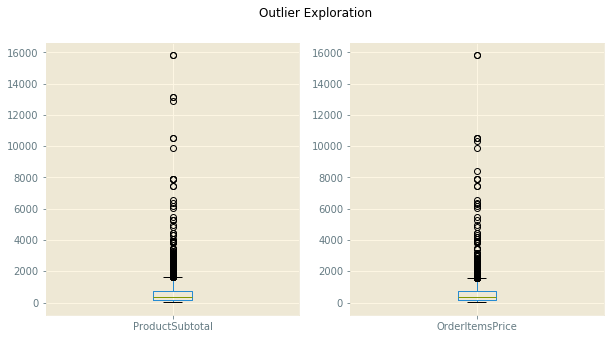

In [104]:
# outlier identification
print('length of cleaner dataset: ' + str(len(sort1)))

fig01 = plt.figure(figsize=(10,5))
fig01.suptitle('Outlier Exploration')

ax = fig01.add_subplot(121)
ax1 = sort1.ProductSubtotal.plot(kind='box')
ax = fig01.add_subplot(122)
ax2 = sort1.OrderItemsPrice.plot(kind='box')

length of cleaner dataset: 2137


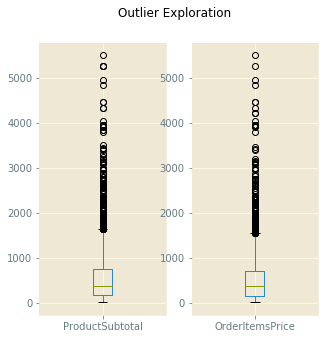

In [105]:
# management of outliers
no_outliers = sort1.loc[sort1['ProductSubtotal'] < 6000]
no_outliers = no_outliers.loc[no_outliers['OrderItemsPrice'] < 6000]
print('length of cleaner dataset: ' + str(len(no_outliers)))

fig02 = plt.figure(figsize=(5,5))
fig02.suptitle('Outlier Exploration')

ax = fig02.add_subplot(121)
ax1 = no_outliers.ProductSubtotal.plot(kind='box')
ax = fig02.add_subplot(122)
ax2 = no_outliers.OrderItemsPrice.plot(kind='box')

There seems to be quite a few outliers still. I'm hoping that an exploration will reveal them so that they can be removed.

# Explore Data

For a quick preview of what we have to work with, we'll use the describe method.

In [106]:
# describe data
no_outliers.describe()

,Freight,ProductPrice,OrderPrice,Quantity,ReorderLevel,ProductSubtotal,OrderItemsPrice
count,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000
mean,92.799832,26.422209,24.800772,23.557791,11.911558,597.024244,558.012817
std,125.724000,25.995731,24.745604,18.748472,10.818910,689.402772,647.036862
min,0.020000,2.500000,2.000000,1.000000,0.000000,6.000000,4.800000
25%,18.840000,12.500000,12.000000,10.000000,0.000000,168.000000,153.000000
50%,53.050000,19.450000,18.400000,20.000000,10.000000,375.000000,360.000000
75%,116.530000,34.000000,31.230000,30.000000,20.000000,757.800000,714.000000
max,1007.640000,263.500000,263.500000,130.000000,30.000000,5500.000000,5500.000000


So far, the best looking data is quantity. However, our target information is Item Total.

### Visualize data

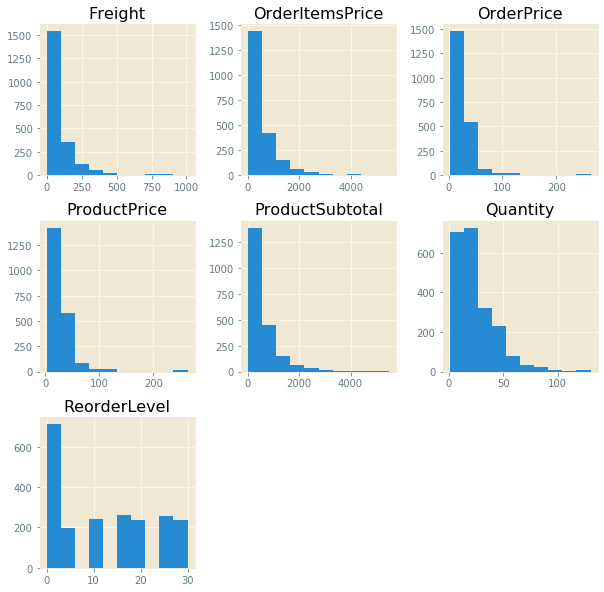

In [107]:
# visualize data
no_outliers.hist(figsize=(10,10));

This data looks like it needs a log transformation to be predictable. Alternatively, a non-parametric test could be used on the original data.

### Log Transformation

In [75]:
# # sort data
# log_freight = no_outliers['Freight'].applymap(lambda x: np.log(x))
# log_itemTotal = no_outliers['ItemTotal'].applymap(lambda x: np.log(x))
# log_quantity = no_outliers['Quantity'].applymap(lambda x: np.log(x))
# log_unitPrice = no_outliers['UnitPrice'].applymap(lambda x: np.log(x))

# no_outliers.loc['Freight'] = log_freight
# no_outliers.loc['ItemTotal'] = log_itemTotal
# no_outliers.loc['Quantity'] = log_quantity
# no_outliers.loc['UnitPrice'] = log_unitPrice

Observations about sorted data

# Model Data
Below is the model after scrubbing and exploring have been managed, let's see what the model picks up.

### Data normality

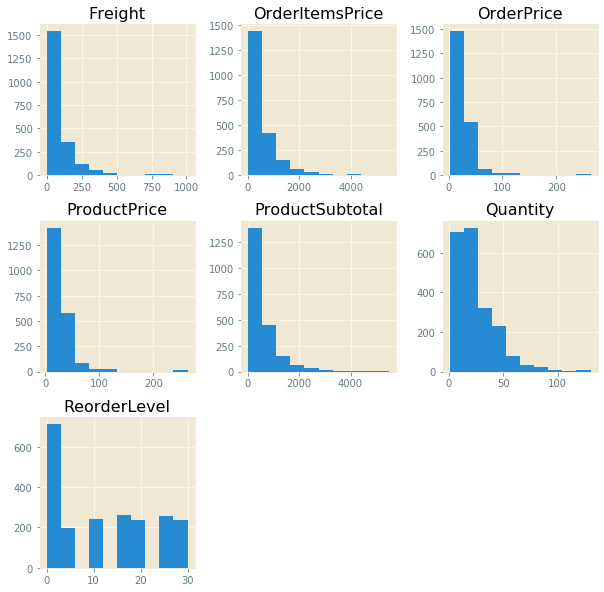

In [109]:
# visual/code for data normality
no_outliers.hist(figsize=(10,10));

### Standard deviation

In [110]:
# standard deviation for target variable
print('ProductSubtotal')
print('mean: ' + str(mean(no_outliers['ProductSubtotal'])))
print('standard deviation: ' + str(std(no_outliers['ProductSubtotal'])))

print('OrderDetailSubtotal')
print('mean: ' + str(mean(no_outliers['OrderItemsPrice'])))
print('standard deviation: ' + str(std(no_outliers['OrderItemsPrice'])))

ProductSubtotal
mean: 597.0242442676649
standard deviation: 689.2414520333434
OrderDetailSubtotal
mean: 558.0128170332242
standard deviation: 646.8854554782721


Definately use non-parametric testing

### Basic testing

In [111]:
# set up variables for this particular test
product = no_outliers['ProductSubtotal']
orderDetail = no_outliers['OrderItemsPrice']

In [112]:
# test
stats.ttest_rel(product, orderDetail)

Ttest_relResult(statistic=18.21562317392649, pvalue=4.976459890978798e-69)

In [113]:
# result
p_value = 4.976459890978798 * 10**-69

In [ ]:
# evaluation of result
pass

Summarize results and determine next steps. Might include verification of sample size, error types, non-parametric testing, or a deepening of understanding

### Verification techniques
#### Non-parametric testing

In [ ]:
# non-parametric testing variables
pass

In [ ]:
# non-parametric test
pass

In [ ]:
# result
p_value = ''

In [ ]:
# evaluation of results
pass

Oberservations based on new finding

#### Effect size

In [ ]:
# effect size variables
pass

In [ ]:
# effect size test
pass

In [ ]:
# result
p_value = ''

In [ ]:
# evalation of result
pass

Obeservations about effect size

#### Power and error

In [ ]:
# power variables
pass

In [ ]:
# power test
pass

In [ ]:
# power result
p_value = ''

In [ ]:
# evaluation of power test
pass

Observations about power test

### Cross validatation

In [ ]:
# test train split for testing preformed above
pass

### Extension of acquired knowledge
#### Deeper question
#### Hypothesis for deeper question

In [ ]:
# deeper understanding variables
pass

In [ ]:
# deeper understanding test
pass

In [ ]:
# deeper understanding result
p_value = ''

In [ ]:
# deeper understanding evaluation of result
pass

Observations based off of deeper understanding test

# Interpret

Conclusions about question overall commentary on hypothesis

### Additional visualizations

In [ ]:
# visual for blah blah blah
pass

### Tools for use of discovered information

In [ ]:
# function or equation used to test developed theories
pass

# Future Work

give a list of options for future exploration opportunities

# Resources

MultiIndexing Data
http://zaxrosenberg.com/pandas-multiindex-tutorial/
https://www.youtube.com/watch?v=kP-0ET0V5Tc